In [5]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

This ensures that any operations involving randomness in a code (our models that case) will produce the same results every time the notebook is run.

In [6]:
import numpy as np
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

This code loads five different driver datasets,
prints their shapes to check data size
& groups them into a list for easier processing later:

In [7]:
import pandas as pd

# Load datasets
d1 = pd.read_csv("data/D1_phase2_FINAL.csv")
d2 = pd.read_csv("data/D2_phase2_FINAL.csv")
d3 = pd.read_csv("data/D3_phase2_FINAL.csv")
d4 = pd.read_csv("data/D4_phase2_FINAL.csv")
d5 = pd.read_csv("data/D5_phase2_FINAL.csv")

print(d1.shape)
print(d2.shape)
print(d3.shape)
print(d4.shape)
print(d5.shape)

drivers = [d1, d2, d3, d4, d5]

(1617, 42)
(1906, 42)
(2964, 42)
(2273, 42)
(1667, 42)


This code converts road type to numbers because ML only understands models only understand numbers, then we created a new feature that shows how fast the driver is going relative to the allowed speed:

In [8]:
ROAD_MAP = {
    "motor": 1,
    "secondary": 0
}

for df in [d1, d2, d3, d4, d5]:
    df["road_type"] = df["road_type"].map(ROAD_MAP)
    df["speed_ratio"] = df["speed_kmh"] / df["max_speed"]

In [9]:
print("D1 duplicate rows:", d1.duplicated().sum())
print("D2 duplicate rows:", d2.duplicated().sum())
print("D3 duplicate rows:", d3.duplicated().sum())
print("D4 duplicate rows:", d4.duplicated().sum())
print("D4 duplicate rows:", d5.duplicated().sum())

D1 duplicate rows: 16
D2 duplicate rows: 0
D3 duplicate rows: 0
D4 duplicate rows: 24
D4 duplicate rows: 0


In [10]:
d1 = d1.drop_duplicates().reset_index(drop=True)
d2 = d2.drop_duplicates().reset_index(drop=True)
d3 = d3.drop_duplicates().reset_index(drop=True)
d4 = d4.drop_duplicates().reset_index(drop=True)
d5 = d5.drop_duplicates().reset_index(drop=True)

This code defines the exact input features used for classification:

In [11]:
LABEL_COL = "behavior"

NON_FEATURE_COLS = [
    "t_sec",            #time
    "driver",           #driver id
    LABEL_COL,          #label
    "road_type_osm",
    "road_type",
    "lane_id"
]

def get_feature_columns(df, non_feature_cols):
    return [c for c in df.columns if c not in non_feature_cols]

feature_cols = get_feature_columns(d1, NON_FEATURE_COLS)

print("Number of features:", len(feature_cols))
print(feature_cols)

Number of features: 37
['speed_kmh', 'lat', 'lon', 'alt', 'vert_acc', 'horiz_acc', 'course', 'difcourse', 'hdop', 'vdop', 'pdop', 'active', 'acc_x', 'acc_y', 'acc_z', 'acc_x_kf', 'acc_y_kf', 'acc_z_kf', 'roll', 'pitch', 'yaw', 'x_lane', 'phi', 'road_width', 'lane_state', 'dist_front', 'ttc_front', 'num_vehicles', 'gps_speed', 'max_speed', 'speed_rel', 'num_lanes', 'lat_osm', 'lon_osm', 'osm_delay', 'gps_speed_osm', 'speed_ratio']


In [12]:
motor_drivers = []
secondary_drivers = []

for df in drivers:
    motor_df = df[df["road_type"] == 1].reset_index(drop=True)
    secondary_df = df[df["road_type"] == 0].reset_index(drop=True)

    motor_drivers.append(motor_df)
    secondary_drivers.append(secondary_df)

In [13]:
for i, (m_df, s_df) in enumerate(zip(motor_drivers, secondary_drivers), start=1):
    print(f"D{i} motor rows:", len(m_df))
    print(f"D{i} secondary rows:", len(s_df))
    print("-" * 30)

D1 motor rows: 1077
D1 secondary rows: 540
------------------------------
D2 motor rows: 1195
D2 secondary rows: 711
------------------------------
D3 motor rows: 1656
D3 secondary rows: 1308
------------------------------
D4 motor rows: 1494
D4 secondary rows: 779
------------------------------
D5 motor rows: 946
D5 secondary rows: 721
------------------------------


This code tells which column is the class label & defines the exact behaviors:

In [14]:
LABEL_COL = "behavior"
LABEL_ORDER = ["Normal", "Aggressive", "Drowsy"]

We created a helper function to split each driver’s data by driving behavior to ensure clean separation between classes before training.

In [15]:
def split_by_behavior(df, label_col, label_order):
    splits = {}
    for label in label_order:
        part = df[df[label_col] == label].reset_index(drop=True)
        if len(part) > 0:
            splits[label] = part
    return splits

In [16]:
motor_behavior_drivers = []

for i, df in enumerate(motor_drivers, start=1):
    splits = split_by_behavior(df, LABEL_COL, LABEL_ORDER)
    motor_behavior_drivers.append(splits)
    print(f"D{i} MOTOR behaviors:", {k: len(v) for k, v in splits.items()})

D1 MOTOR behaviors: {'Normal': 377, 'Aggressive': 371, 'Drowsy': 329}
D2 MOTOR behaviors: {'Normal': 415, 'Aggressive': 340, 'Drowsy': 440}
D3 MOTOR behaviors: {'Normal': 575, 'Aggressive': 475, 'Drowsy': 606}
D4 MOTOR behaviors: {'Normal': 500, 'Aggressive': 462, 'Drowsy': 532}
D5 MOTOR behaviors: {'Normal': 273, 'Aggressive': 275, 'Drowsy': 398}


In [17]:
secondary_behavior_drivers = []

for i, df in enumerate(secondary_drivers, start=1):
    splits = split_by_behavior(df, LABEL_COL, LABEL_ORDER)
    secondary_behavior_drivers.append(splits)
    print(f"D{i} SECONDARY behaviors:", {k: len(v) for k, v in splits.items()})

D1 SECONDARY behaviors: {'Normal': 161, 'Aggressive': 183, 'Drowsy': 196}
D2 SECONDARY behaviors: {'Normal': 204, 'Aggressive': 199, 'Drowsy': 308}
D3 SECONDARY behaviors: {'Normal': 430, 'Aggressive': 426, 'Drowsy': 452}
D4 SECONDARY behaviors: {'Normal': 384, 'Aggressive': 172, 'Drowsy': 223}
D5 SECONDARY behaviors: {'Normal': 266, 'Aggressive': 147, 'Drowsy': 308}


This code converts behavior labels from text to numbers which is mandatory for ML models:

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(LABEL_ORDER)

print(dict(zip(label_encoder.classes_,
               label_encoder.transform(label_encoder.classes_))))

{np.str_('Aggressive'): np.int64(0), np.str_('Drowsy'): np.int64(1), np.str_('Normal'): np.int64(2)}


Now this code converts continuous sensor data into fixed-length time windows which are used as training samples.

Each window:

Represents a short driving segment

Has 64 time steps

Moves forward by 32 steps (overlap)

In [19]:
def window_data(df, feature_cols, label,
                window_size=64, stride=32):

    X, y = [], []
    window_rows = []

    features = df[feature_cols].values

    for i in range(0, len(features) - window_size + 1, stride):
        window = features[i:i+window_size]

        # model input
        X.append(window)
        y.append(label)

        # explainability features (per window)
        row = {}
        for j, col in enumerate(feature_cols):
            row[f"{col}_mean"] = window[:, j].mean()

        row["label"] = label
        window_rows.append(row)

    return np.array(X), np.array(y), pd.DataFrame(window_rows)

## THIS IS WINDOWING FOR MOTOR DATA

In this step, we generate windowed motor-road data per driver by first separating behaviors, encoding labels, applying sliding windows & then merging all behavior windows for each driver while preserving driver boundaries.

In [20]:
X_motor_by_driver = []
y_motor_by_driver = []
motor_window_dfs = []

for driver_splits in motor_behavior_drivers:
    X_driver, y_driver = [], []

    for behavior, df_part in driver_splits.items():
        label_id = label_encoder.transform([behavior])[0]

        X_tmp, y_tmp, window_df_tmp = window_data(df_part,feature_cols,label_id)

        if len(X_tmp) > 0:
            X_driver.append(X_tmp)
            y_driver.append(y_tmp)
            motor_window_dfs.append(window_df_tmp)

    if len(X_driver) > 0:
        X_motor_by_driver.append(np.concatenate(X_driver, axis=0))
        y_motor_by_driver.append(np.concatenate(y_driver, axis=0))


#X_motor = np.concatenate(X_motor, axis=0)
#y_motor = np.concatenate(y_motor, axis=0)
motor_window_df = pd.concat(motor_window_dfs, ignore_index=True)
print("Motor window df shape:", motor_window_df.shape)

for i in range(len(X_motor_by_driver)):
    print(f"Driver {i+1} motor windows:", X_motor_by_driver[i].shape)


Motor window df shape: (174, 38)
Driver 1 motor windows: (29, 64, 37)
Driver 2 motor windows: (32, 64, 37)
Driver 3 motor windows: (46, 64, 37)
Driver 4 motor windows: (42, 64, 37)
Driver 5 motor windows: (25, 64, 37)


## THIS IS WINDOWING FOR SECONDARY DATA

In [21]:
X_secondary_by_driver = []
y_secondary_by_driver = []
secondary_window_dfs = []


for driver_splits in secondary_behavior_drivers:
    X_driver, y_driver = [], []

    for behavior, df_part in driver_splits.items():
        label_id = label_encoder.transform([behavior])[0]

        X_tmp, y_tmp, window_df_tmp = window_data(df_part,feature_cols,label_id)

        if len(X_tmp) > 0:
            X_driver.append(X_tmp)
            y_driver.append(y_tmp)
            secondary_window_dfs.append(window_df_tmp)


    if len(X_driver) > 0:
        X_secondary_by_driver.append(np.concatenate(X_driver, axis=0))
        y_secondary_by_driver.append(np.concatenate(y_driver, axis=0))

#X_secondary = np.concatenate(X_secondary, axis=0)
#y_secondary = np.concatenate(y_secondary, axis=0)
secondary_window_df = pd.concat(secondary_window_dfs, ignore_index=True)
print("Secondary window df shape:", secondary_window_df.shape)

for i in range(len(X_secondary_by_driver)):
    print(f"Driver {i+1} secondary windows:", X_secondary_by_driver[i].shape)

Secondary window df shape: (106, 38)
Driver 1 secondary windows: (13, 64, 37)
Driver 2 secondary windows: (18, 64, 37)
Driver 3 secondary windows: (37, 64, 37)
Driver 4 secondary windows: (20, 64, 37)
Driver 5 secondary windows: (18, 64, 37)


In [22]:
# ===== STEP 1: Check window uniqueness (SECONDARY) =====

def count_unique_windows(X):
    flat = X.reshape(X.shape[0], -1)
    return len(np.unique(flat, axis=0))

X_sec_train_all = np.concatenate(X_secondary_by_driver[:4], axis=0)
X_sec_test = X_secondary_by_driver[4]

print("Secondary TRAIN windows:", X_sec_train_all.shape[0])
print("Secondary TRAIN unique:", count_unique_windows(X_sec_train_all))

print("Secondary TEST windows:", X_sec_test.shape[0])
print("Secondary TEST unique:", count_unique_windows(X_sec_test))

Secondary TRAIN windows: 88
Secondary TRAIN unique: 88
Secondary TEST windows: 18
Secondary TEST unique: 18


In [23]:
motor_window_df.to_csv("motor_window_features.csv", index=False)
secondary_window_df.to_csv("secondary_window_features.csv", index=False)

## TRAIN - TEST SPLITS FOR MOTOR DATA

In [24]:
from sklearn.model_selection import train_test_split

# ===== DRIVER-BASED SPLIT (MOTOR) =====

#train: drivers 1–3
X_motor_train = np.concatenate(X_motor_by_driver[:3], axis=0)
y_motor_train = np.concatenate(y_motor_by_driver[:3], axis=0)

#test: driver 4-5
X_motor_test = np.concatenate(X_motor_by_driver[:3], axis=0)
y_motor_test = np.concatenate(y_motor_by_driver[:3], axis=0)


#validation split inside training drivers only
X_motor_train, X_motor_val, y_motor_train, y_motor_val = train_test_split(
    X_motor_train,
    y_motor_train,
    test_size=0.3,
    random_state=42,
    stratify=y_motor_train
)

print("Motor TRAIN:", X_motor_train.shape)
print("Motor VAL  :", X_motor_val.shape)
print("Motor TEST :", X_motor_test.shape)


Motor TRAIN: (74, 64, 37)
Motor VAL  : (33, 64, 37)
Motor TEST : (107, 64, 37)


In [25]:
# ===== MOTOR CLASS WEIGHTS =====
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

motor_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_motor_train),
    y=y_motor_train
)

motor_class_weights = dict(enumerate(motor_class_weights))
print("Motor class weights:", motor_class_weights)

Motor class weights: {0: np.float64(1.121212121212121), 1: np.float64(0.9487179487179487), 2: np.float64(0.9487179487179487)}


In [26]:
# ===== MOTOR: Window-level balancing (TRAIN ONLY) =====

def balance_windows(X, y):
    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        idx = idx[:min_count]

        X_balanced.append(X[idx])
        y_balanced.append(y[idx])

    return np.concatenate(X_balanced), np.concatenate(y_balanced)


print("Motor BEFORE balancing:", np.bincount(y_motor_train))

X_motor_train, y_motor_train = balance_windows(
    X_motor_train, y_motor_train
)

print("Motor AFTER balancing:", np.bincount(y_motor_train))

Motor BEFORE balancing: [22 26 26]
Motor AFTER balancing: [22 22 22]


## MOTOR NORMALIZATION

In this code we normalize windowed data using StandardScaler
fitting only on training samples to avoid data leakage.
The data is flattened for scaling and then reshaped to preserve temporal structure (means the order of sensor readings over time remains unchanged after preprocessing)

In [27]:
from sklearn.preprocessing import StandardScaler
import numpy as np

motor_scaler = StandardScaler()

X_motor_train_flat = X_motor_train.reshape(-1, X_motor_train.shape[-1])
motor_scaler.fit(X_motor_train_flat)

def scale_windows(X, scaler):
    X_flat = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.transform(X_flat)
    return X_scaled.reshape(X.shape)

X_motor_train_norm = scale_windows(X_motor_train, motor_scaler)
X_motor_val_norm   = scale_windows(X_motor_val, motor_scaler)
X_motor_test_norm  = scale_windows(X_motor_test, motor_scaler)

print("Motor normalization done:")
print("Train:", X_motor_train_norm.shape)
print("Val:  ", X_motor_val_norm.shape)
print("Test: ", X_motor_test_norm.shape)

Motor normalization done:
Train: (66, 64, 37)
Val:   (33, 64, 37)
Test:  (107, 64, 37)


## TRAIN - TEST SPLITS FOR SECONDARY DATA

In [28]:
# ===== DRIVER-BASED SPLIT (SECONDARY) =====

#train: drivers 1–3
X_secondary_train = np.concatenate(X_secondary_by_driver[:3], axis=0)
y_secondary_train = np.concatenate(y_secondary_by_driver[:3], axis=0)

#test: driver 4-5
X_secondary_test = np.concatenate(X_secondary_by_driver[3:], axis=0)
y_secondary_test = np.concatenate(y_secondary_by_driver[3:], axis=0)

# validation split from training drivers only
X_secondary_train, X_secondary_val, y_secondary_train, y_secondary_val = train_test_split(
    X_secondary_train,
    y_secondary_train,
    test_size=0.45,
    random_state=42,
    stratify=y_secondary_train
)

print("Secondary TRAIN:", X_secondary_train.shape)
print("Secondary VAL  :", X_secondary_val.shape)
print("Secondary TEST :", X_secondary_test.shape)


Secondary TRAIN: (37, 64, 37)
Secondary VAL  : (31, 64, 37)
Secondary TEST : (38, 64, 37)


In [29]:
# ===== SECONDARY CLASS WEIGHTS =====
#secondary_class_weights = compute_class_weight(
#    class_weight="balanced",
#    classes=np.unique(y_secondary_train),
#    y=y_secondary_train
#)

#secondary_class_weights = dict(enumerate(secondary_class_weights))
#print("Secondary class weights:", secondary_class_weights)

In [30]:
# ===== STEP 2: Window-level balancing (SECONDARY TRAIN ONLY) =====

def balance_windows(X, y):
    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        idx = idx[:min_count]

        X_balanced.append(X[idx])
        y_balanced.append(y[idx])

    return np.concatenate(X_balanced), np.concatenate(y_balanced)


print("Before balancing:", np.bincount(y_secondary_train))

X_secondary_train, y_secondary_train = balance_windows(
    X_secondary_train, y_secondary_train
)

print("After balancing:", np.bincount(y_secondary_train))

Before balancing: [11 14 12]
After balancing: [11 11 11]


## SECONDARY NORMALIZATION

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np

secondary_scaler = StandardScaler()

X_secondary_train_norm = secondary_scaler.fit_transform(
    X_secondary_train.reshape(-1, X_secondary_train.shape[-1])
).reshape(X_secondary_train.shape)

X_secondary_val_norm = secondary_scaler.transform(
    X_secondary_val.reshape(-1, X_secondary_val.shape[-1])
).reshape(X_secondary_val.shape)

X_secondary_test_norm = secondary_scaler.transform(
    X_secondary_test.reshape(-1, X_secondary_test.shape[-1])
).reshape(X_secondary_test.shape)

print("Secondary normalization done:")
print("Train:", X_secondary_train_norm.shape)
print("Val:  ", X_secondary_val_norm.shape)
print("Test: ", X_secondary_test_norm.shape)

Secondary normalization done:
Train: (33, 64, 37)
Val:   (31, 64, 37)
Test:  (38, 64, 37)


### NOW WE ARE DONE WITH PREPROCESSING AND WINDOWING FOR BOTH MOTOR AND SECONDARY

This model combines 2 ideas:
LSTM to understand how driving changes over time
& CNN (FCN) to detect important local motion patterns in sensor data.

We define the model as a function so it can be reused with different datasets.

Each input sample is a sequence of sensor readings over time. (the windows that we created)

The CNN part learns short-term driving patterns like acceleration or braking by sliding filters over time.

In [32]:
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Conv1D,
    BatchNormalization,
    Activation,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy



def build_lstm_fcn(input_shape, num_classes):
    """
    LSTM-FCN model
    input_shape = (timesteps, features)
    num_classes = number of behavior classes (3)
    """

    inputs = Input(shape=input_shape)

    # ----- LSTM branch -----
    lstm_out = LSTM(
        units=64,
        dropout=0.4,
        recurrent_dropout=0.0,
        return_sequences=False
    )(inputs)

    #Reads the window step by step, remembers important trends and then outputs one summary vector per window
    #for example: Gradual drowsiness, sustained aggressive driving & speed trends over time.

    # ----- FCN branch -----
    x = Conv1D(filters=128, kernel_size=8, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters=256, kernel_size=5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling1D()(x)

    # ----- Merge LSTM + FCN -----
    merged = Concatenate()([lstm_out, x])
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.3)(merged)

    outputs = Dense(num_classes, activation="softmax")(merged)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
        )


    return model

## TRAIN MOTOR MODEL

In [33]:
motor_model = build_lstm_fcn(
    input_shape=X_motor_train_norm.shape[1:],
    num_classes=3
)

motor_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 128)   │     38,016 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 256)   │    164,096 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 128)   │     98,432 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     26,112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,795 (1.35 MB)

 Trainable params: 352,771 (1.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=18,
    restore_best_weights=True
)

In [35]:
history_motor = motor_model.fit(
    X_motor_train_norm,
    y_motor_train,
    validation_data=(X_motor_val_norm, y_motor_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.5152 - loss: 1.0652 - val_accuracy: 0.3636 - val_loss: 0.9704
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7576 - loss: 0.6856 - val_accuracy: 0.4848 - val_loss: 0.9222
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8030 - loss: 0.5856 - val_accuracy: 0.5758 - val_loss: 0.8818
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8485 - loss: 0.4893 - val_accuracy: 0.6061 - val_loss: 0.8484
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8788 - loss: 0.4268 - val_accuracy: 0.6364 - val_loss: 0.8171
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9242 - loss: 0.3330 - val_accuracy: 0.6667 - val_loss: 0.7900
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9394 - loss: 0.2794 - val_accuracy: 0.6667 - val_loss: 0.7627
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.2215 - val_accuracy: 0.6364 - val_loss: 0.7394

In [36]:
motor_test_loss, motor_test_acc = motor_model.evaluate(
    X_motor_test_norm,
    y_motor_test,
    verbose=1
)

print("MOTOR Test accuracy:", motor_test_acc)
print("MOTOR Test loss:", motor_test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9439 - loss: 0.1528
MOTOR Test accuracy: 0.9439252614974976
MOTOR Test loss: 0.1528254747390747


## TRAIN SECONDARY MODEL

In [37]:
secondary_class_weights = {
    0: 1.4,  # Aggressive → penalize mistakes more
    1: 1.0,  # Drowsy → already perfect
    2: 1.0   # Normal
}

print("Secondary class weights (manual):", secondary_class_weights)

Secondary class weights (manual): {0: 1.4, 1: 1.0, 2: 1.0}


In [38]:
secondary_model = build_lstm_fcn(
    input_shape=X_secondary_train_norm.shape[1:],
    num_classes=3
)

secondary_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64, 128)   │     38,016 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 256)   │    164,096 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256)   │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 64, 128)   │     98,432 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     26,112 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_5[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,795 (1.35 MB)

 Trainable params: 352,771 (1.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [39]:
history_secondary = secondary_model.fit(
    X_secondary_train_norm,
    y_secondary_train,
    validation_data=(X_secondary_val_norm, y_secondary_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=secondary_class_weights,
    verbose=1
)


Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - accuracy: 0.3030 - loss: 1.3863 - val_accuracy: 0.5484 - val_loss: 1.0286
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8182 - loss: 0.7645 - val_accuracy: 0.5806 - val_loss: 0.9805
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9091 - loss: 0.6015 - val_accuracy: 0.6129 - val_loss: 0.9335
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9697 - loss: 0.4670 - val_accuracy: 0.5806 - val_loss: 0.8884
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9697 - loss: 0.3555 - val_accuracy: 0.6129 - val_loss: 0.8445
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9697 - loss: 0.3219 - val_accuracy: 0.6774 - val_loss: 0.8029
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9091 - loss: 0.2855 - val_accuracy: 0.7097 - val_loss: 0.7616
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9697 - loss: 0.2439 - val_accuracy: 0.7742 - val_loss: 0.721

In [40]:
secondary_test_loss, secondary_test_acc = secondary_model.evaluate(
    X_secondary_test_norm,
    y_secondary_test,
    verbose=1
)

print("SECONDARY Test accuracy:", secondary_test_acc)
print("SECONDARY Test loss:", secondary_test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5789 - loss: 1.0113
SECONDARY Test accuracy: 0.5789473652839661
SECONDARY Test loss: 1.011347770690918


In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


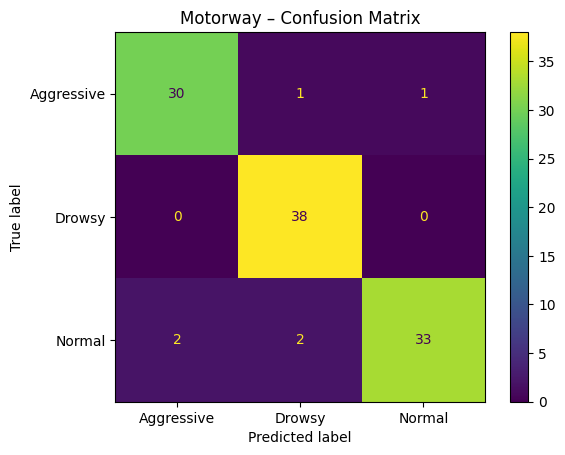

In [42]:
# ----- MOTOR MODEL -----

#predict probabilities
y_motor_pred_prob = motor_model.predict(X_motor_test_norm)

#convert to class labels
y_motor_pred = np.argmax(y_motor_pred_prob, axis=1)

#true labels
y_motor_true = y_motor_test

#confusion matrix
cm_motor = confusion_matrix(y_motor_true, y_motor_pred)

disp_motor = ConfusionMatrixDisplay(
    confusion_matrix=cm_motor,
    display_labels=["Aggressive", "Drowsy", "Normal"]
)

disp_motor.plot(cmap="viridis")
plt.title("Motorway – Confusion Matrix")
plt.show()


In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_motor_true, y_motor_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9375    0.9375    0.9375        32
           1     0.9268    1.0000    0.9620        38
           2     0.9706    0.8919    0.9296        37

    accuracy                         0.9439       107
   macro avg     0.9450    0.9431    0.9430       107
weighted avg     0.9452    0.9439    0.9435       107



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


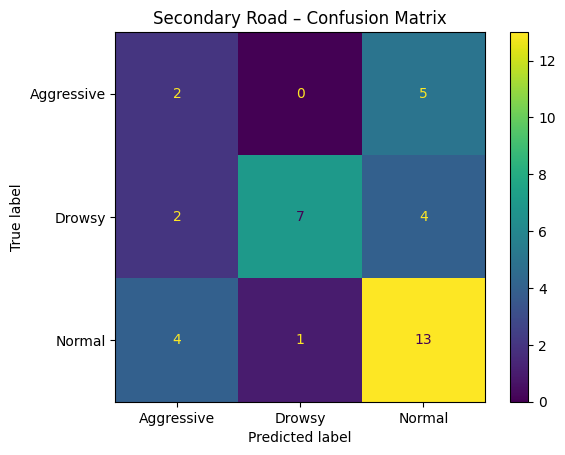

In [44]:
# ----- SECONDARY MODEL -----

#predict probabilities
y_secondary_pred_prob = secondary_model.predict(X_secondary_test_norm)

#convert to class labels
y_secondary_pred = np.argmax(y_secondary_pred_prob, axis=1)

#true labels
y_secondary_true = y_secondary_test

#confusion matrix
cm_secondary = confusion_matrix(y_secondary_true, y_secondary_pred)

disp_secondary = ConfusionMatrixDisplay(
    confusion_matrix=cm_secondary,
    display_labels=["Aggressive", "Drowsy", "Normal"]
)

disp_secondary.plot(cmap="viridis")
plt.title("Secondary Road – Confusion Matrix")
plt.show()

this function applies majority voting across nearby windows to reduce noisy, isolated misclassifications.

In [45]:
def smooth_predictions(preds, window=3):
    smoothed = preds.copy()

    for i in range(len(preds)):
        start = max(0, i - window)
        end = min(len(preds), i + window + 1)

        counts = np.bincount(preds[start:end], minlength=3)
        majority = counts.argmax()
        confidence = counts[majority] / counts.sum()

        # Protect Drowsy (class 1)
        if preds[i] == 1:
            smoothed[i] = 1

        # Normal -> Aggressive only with strong evidence
        elif preds[i] == 2:
            if counts[0] >= 3 and confidence >= 0.6:
                smoothed[i] = 0
            else:
                smoothed[i] = 2

        # Aggressive needs confirmation
        else:  # preds[i] == 0
            smoothed[i] = 0 if confidence >= 0.6 else preds[i]

    return smoothed


y_secondary_pred_smooth = smooth_predictions(
    y_secondary_pred,
    window=3
)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_secondary_true, y_secondary_pred_smooth, digits=4))

              precision    recall  f1-score   support

           0     0.2500    0.2857    0.2667         7
           1     0.8750    0.5385    0.6667        13
           2     0.5909    0.7222    0.6500        18

    accuracy                         0.5789        38
   macro avg     0.5720    0.5155    0.5278        38
weighted avg     0.6253    0.5789    0.5851        38



## SAVING THE MODELS

In [47]:
#motor_model.save("motor_lstm_fcn.h5")
#secondary_model.save("secondary_lstm_fcn.h5")

In [48]:
#from google.colab import drive
#drive.mount('/content/drive')

In [49]:
#motor_model.save("/content/drive/MyDrive/DriveIQ/motor_lstm_fcn.h5")
#secondary_model.save("/content/drive/MyDrive/DriveIQ/secondary_lstm_fcn.h5")